<a href="https://www.kaggle.com/code/youssefmohhaj89/heart-failure-prediction-accuracy-97?scriptVersionId=157475126" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
import xgboost as xgb
from sklearn.tree  import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
import matplotlib.pylab as plt
from imblearn.over_sampling import SMOTE
from sklearn.preprocessing import MinMaxScaler

# **previewing the data**

In [2]:
df = pd.read_csv("/kaggle/input/heart-failure-prediction/heart_failure_clinical_records.csv")

In [3]:
df.head()

,age,anaemia,creatinine_phosphokinase,diabetes,ejection_fraction,high_blood_pressure,platelets,serum_creatinine,serum_sodium,sex,smoking,time,DEATH_EVENT
0,75.0,0,582,0,20,1,265000.00,1.9,130,1,0,4,1
1,55.0,0,7861,0,38,0,263358.03,1.1,136,1,0,6,1
2,65.0,0,146,0,20,0,162000.00,1.3,129,1,1,7,1
3,50.0,1,111,0,20,0,210000.00,1.9,137,1,0,7,1
4,65.0,1,160,1,20,0,327000.00,2.7,116,0,0,8,1


In [4]:
df.isna().sum()

age                         0
anaemia                     0
creatinine_phosphokinase    0
diabetes                    0
ejection_fraction           0
high_blood_pressure         0
platelets                   0
serum_creatinine            0
serum_sodium                0
sex                         0
smoking                     0
time                        0
DEATH_EVENT                 0
dtype: int64

In [5]:
df.duplicated().sum()

0

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 299 entries, 0 to 298
Data columns (total 13 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   age                       299 non-null    float64
 1   anaemia                   299 non-null    int64  
 2   creatinine_phosphokinase  299 non-null    int64  
 3   diabetes                  299 non-null    int64  
 4   ejection_fraction         299 non-null    int64  
 5   high_blood_pressure       299 non-null    int64  
 6   platelets                 299 non-null    float64
 7   serum_creatinine          299 non-null    float64
 8   serum_sodium              299 non-null    int64  
 9   sex                       299 non-null    int64  
 10  smoking                   299 non-null    int64  
 11  time                      299 non-null    int64  
 12  DEATH_EVENT               299 non-null    int64  
dtypes: float64(3), int64(10)
memory usage: 30.5 KB


In [7]:
corr = df.corr()

<Axes: >

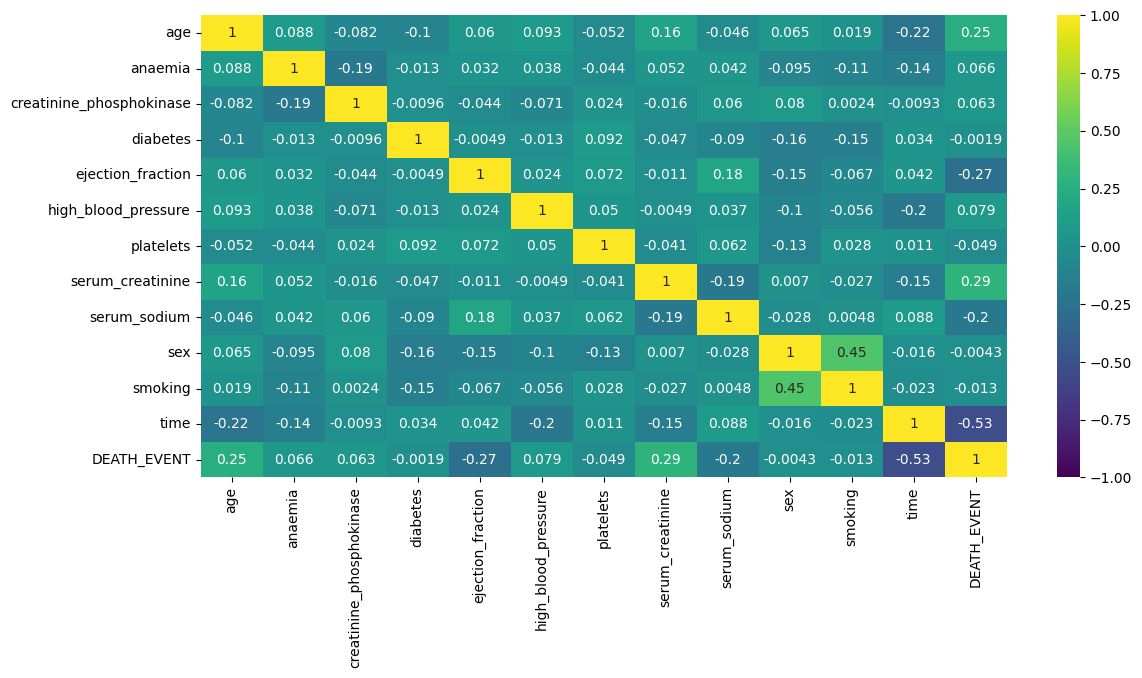

In [8]:
plt.figure(figsize=(13, 6))
sns.heatmap(corr , vmin = -1 , vmax = 1 , annot = True , cmap = "viridis")

# **checking for outliers**

<Axes: >

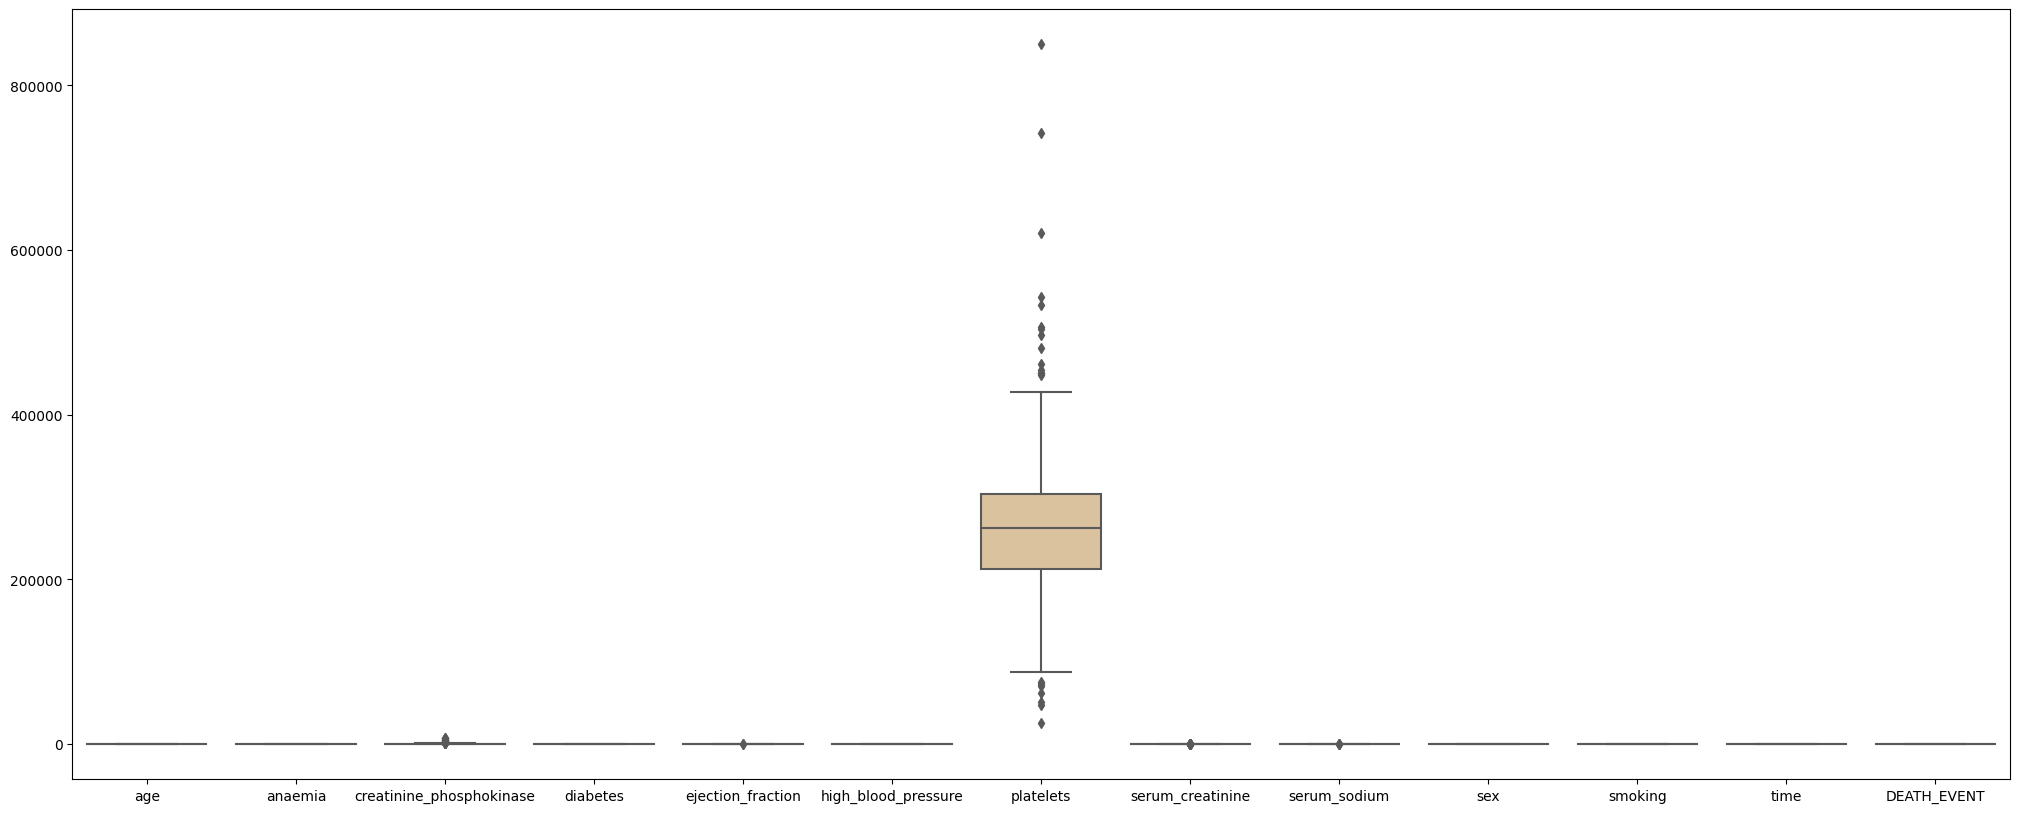

In [9]:
plt.figure(figsize=(25, 10))
sns.boxplot(data=df, orient="v", palette="Set2")

# **dealing with outliers using z-score and winsorize techniques**

In [10]:
def z_score(df, column_name):
    
    x = df[column_name]
    
    q1 = x.quantile(0.25)
    q3 = x.quantile(0.75)
    iqr = q3 - q1
    
    lower_bound = q1 - 1.5 * iqr
    upper_bound = q3 + 1.5 * iqr
    
    outliers = (x < lower_bound) | (x > upper_bound)
    
    df_cleaned = df[~outliers]
    
    return df_cleaned

In [11]:
def winsorize(df, column_name, lower_percentile=0.05, upper_percentile=0.95):
    
    x = df[column_name]
    
    lower_bound = x.quantile(lower_percentile)
    upper_bound = x.quantile(upper_percentile)
    
    
    winsorized_values = np.clip(x, lower_bound, upper_bound)
    
    df_winsorized = df.copy()
    df_winsorized[column_name] = winsorized_values
    
    return df_winsorized


In [12]:
df_cleaned = winsorize(df , "platelets")

In [13]:
df_cleaned = z_score(df_cleaned , "serum_creatinine")

In [14]:
df_cleaned = z_score(df_cleaned , "creatinine_phosphokinase")

In [15]:
df_cleaned = winsorize(df_cleaned , "ejection_fraction")

In [16]:
df_cleaned = winsorize(df_cleaned , "serum_sodium")

<Axes: >

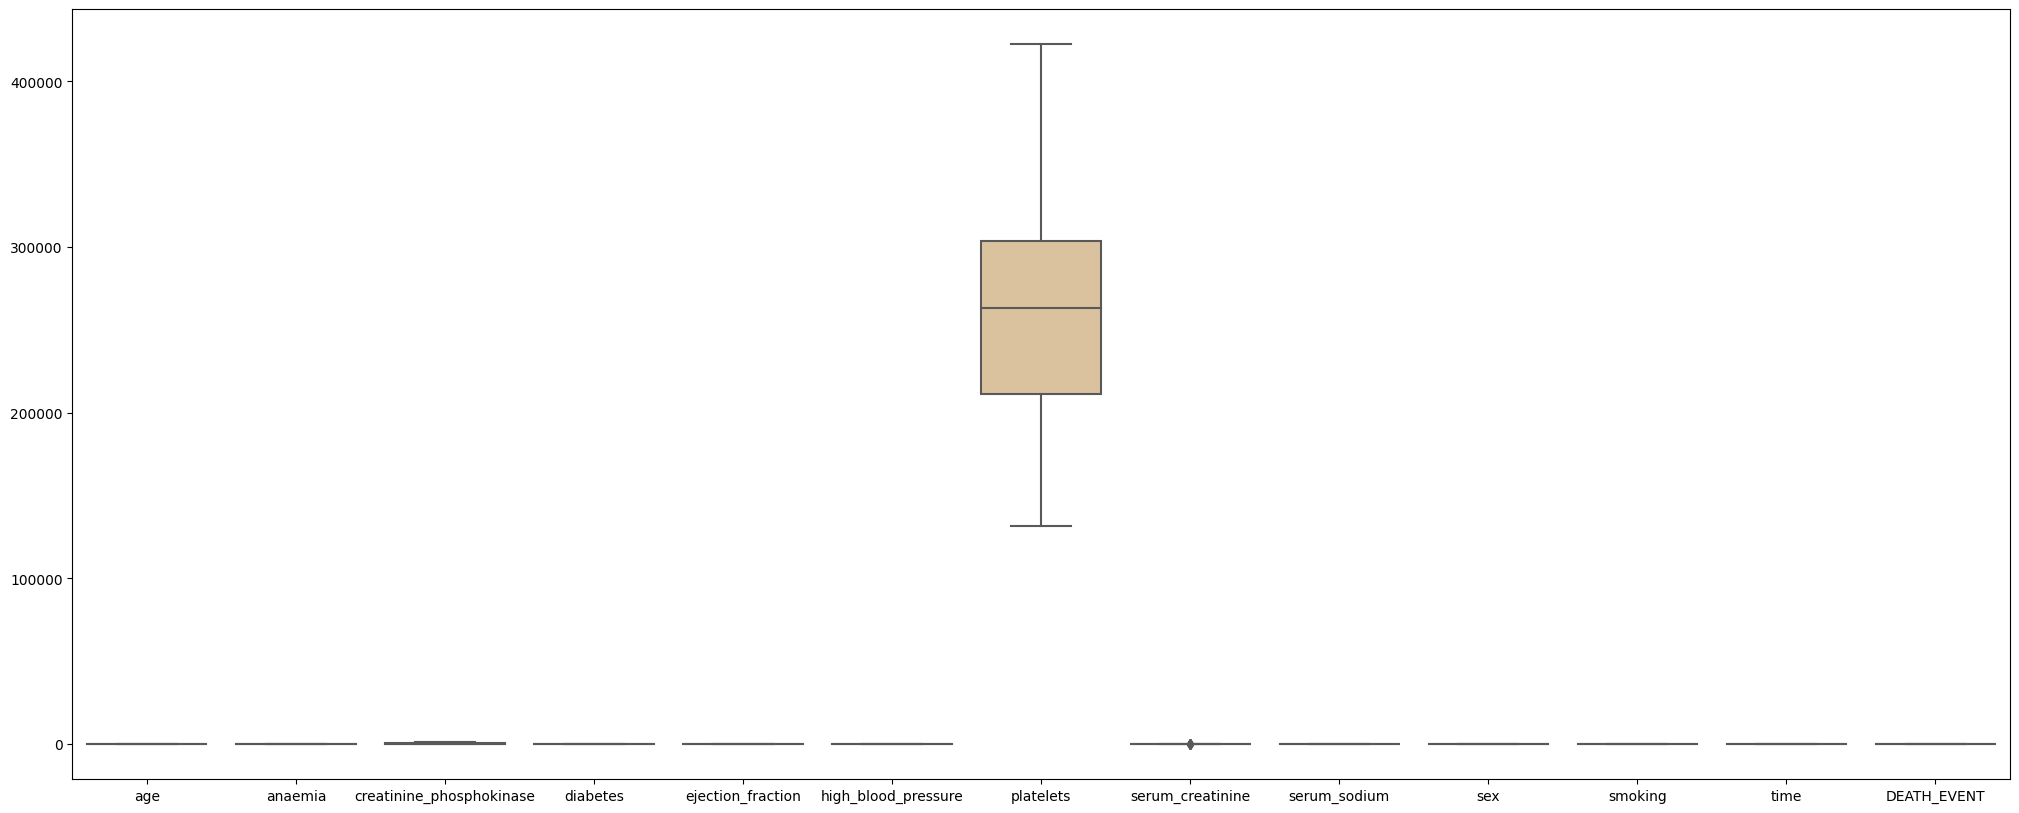

In [17]:
plt.figure(figsize=(25, 10))
sns.boxplot(data=df_cleaned, orient="v", palette="Set2")

# **dealing with imbalanced data**

In [18]:
num_0 = (df_cleaned["DEATH_EVENT"] == 0).sum()
num_1 = (df_cleaned["DEATH_EVENT"] == 1).sum()

print("number of rows with class0:",num_0)
print("number of rows with class1:",num_1)

number of rows with class0: 173
number of rows with class1: 70


In [19]:
x = df_cleaned.drop("DEATH_EVENT" , axis = 1)
y = df_cleaned["DEATH_EVENT"]

In [20]:
smote=SMOTE(random_state=42)
x_resampled, y_resampled = smote.fit_resample(x, y)

In [21]:
num0 = (y_resampled == 0).sum()
num1 = (y_resampled == 1).sum()
print("number of class0: ",num0)
print("number of class1: ",num1)

number of class0:  173
number of class1:  173


# **data augmentation**

In [22]:
data = np.column_stack((x_resampled, y_resampled))

x_balanced = data[:, :-1]
y_balanced = data[:, -1]

num_samples_to_add = 600

additional_samples_indices = np.concatenate([
    np.random.choice(np.where(y_balanced == 0)[0], num_samples_to_add // 2, replace=True),
    np.random.choice(np.where(y_balanced == 1)[0], num_samples_to_add // 2, replace=True)
])

x_augmented = np.vstack([x_balanced, x_balanced[additional_samples_indices]])
y_augmented = np.hstack([y_balanced, y_balanced[additional_samples_indices]])

print("Number of samples after augmentation:")
print("Class 0:", np.sum(y_augmented == 0))
print("Class 1:", np.sum(y_augmented == 1))

Number of samples after augmentation:
Class 0: 473
Class 1: 473


In [23]:
x_train, x_test, y_train, y_test = train_test_split(x_augmented, y_augmented, test_size=0.25, random_state=42)

In [24]:
print(x_train.shape)
print(x_test.shape)
print(y_train.shape)
print(y_test.shape)

(709, 12)
(237, 12)
(709,)
(237,)


In [25]:
z_scaler = StandardScaler()
x_train_scaled = z_scaler.fit_transform(x_train)
x_test_scaled = z_scaler.transform(x_test)

# **trianing phase**

In [26]:
logreg = LogisticRegression(max_iter=2000,random_state=42)
logreg.fit(x_train_scaled, y_train)

y_pred = logreg.predict(x_test_scaled)

accuracy = accuracy_score(y_test, y_pred)
conf_matrix = confusion_matrix(y_test, y_pred)
classification_rep = classification_report(y_test, y_pred)

print(accuracy)
print(conf_matrix)
print(classification_rep)

0.8354430379746836
[[103  16]
 [ 23  95]]
              precision    recall  f1-score   support

         0.0       0.82      0.87      0.84       119
         1.0       0.86      0.81      0.83       118

    accuracy                           0.84       237
   macro avg       0.84      0.84      0.84       237
weighted avg       0.84      0.84      0.84       237



In [27]:
knn = KNeighborsClassifier(n_neighbors= 8)
knn.fit(x_train_scaled , y_train)
y_pred = knn.predict(x_test_scaled)

accuracy = accuracy_score(y_test, y_pred)
conf_matrix = confusion_matrix(y_test, y_pred)
classification_rep = classification_report(y_test, y_pred)

print(accuracy)
print(conf_matrix)
print(classification_rep)

0.869198312236287
[[103  16]
 [ 15 103]]
              precision    recall  f1-score   support

         0.0       0.87      0.87      0.87       119
         1.0       0.87      0.87      0.87       118

    accuracy                           0.87       237
   macro avg       0.87      0.87      0.87       237
weighted avg       0.87      0.87      0.87       237



In [28]:
xgboost = xgb.XGBClassifier(objective="binary:logistic", eval_metric="logloss", random_state=42)

xgboost.fit(x_train_scaled, y_train)
y_pred = xgboost.predict(x_test_scaled)

accuracy = accuracy_score(y_test, y_pred)
conf_matrix = confusion_matrix(y_test, y_pred)
classification_rep = classification_report(y_test, y_pred)

print(accuracy)
print(conf_matrix)
print(classification_rep)

0.9915611814345991
[[119   0]
 [  2 116]]
              precision    recall  f1-score   support

         0.0       0.98      1.00      0.99       119
         1.0       1.00      0.98      0.99       118

    accuracy                           0.99       237
   macro avg       0.99      0.99      0.99       237
weighted avg       0.99      0.99      0.99       237



In [29]:
decision_tree = DecisionTreeClassifier(random_state=42)

decision_tree.fit(x_train_scaled, y_train)

y_pred = decision_tree.predict(x_test_scaled)

accuracy = accuracy_score(y_test, y_pred)
conf_matrix = confusion_matrix(y_test, y_pred)
classification_rep = classification_report(y_test, y_pred)

print(accuracy)
print(conf_matrix)
print(classification_rep)

0.9746835443037974
[[116   3]
 [  3 115]]
              precision    recall  f1-score   support

         0.0       0.97      0.97      0.97       119
         1.0       0.97      0.97      0.97       118

    accuracy                           0.97       237
   macro avg       0.97      0.97      0.97       237
weighted avg       0.97      0.97      0.97       237



In [30]:
random_forest = RandomForestClassifier(max_features= 8 , max_depth=6 , random_state= 42)

random_forest.fit(x_train_scaled, y_train)

y_pred = random_forest.predict(x_test_scaled)

accuracy = accuracy_score(y_test, y_pred)
conf_matrix = confusion_matrix(y_test, y_pred)
classification_rep = classification_report(y_test, y_pred)

print(accuracy)
print(conf_matrix)
print(classification_rep)

0.9789029535864979
[[117   2]
 [  3 115]]
              precision    recall  f1-score   support

         0.0       0.97      0.98      0.98       119
         1.0       0.98      0.97      0.98       118

    accuracy                           0.98       237
   macro avg       0.98      0.98      0.98       237
weighted avg       0.98      0.98      0.98       237



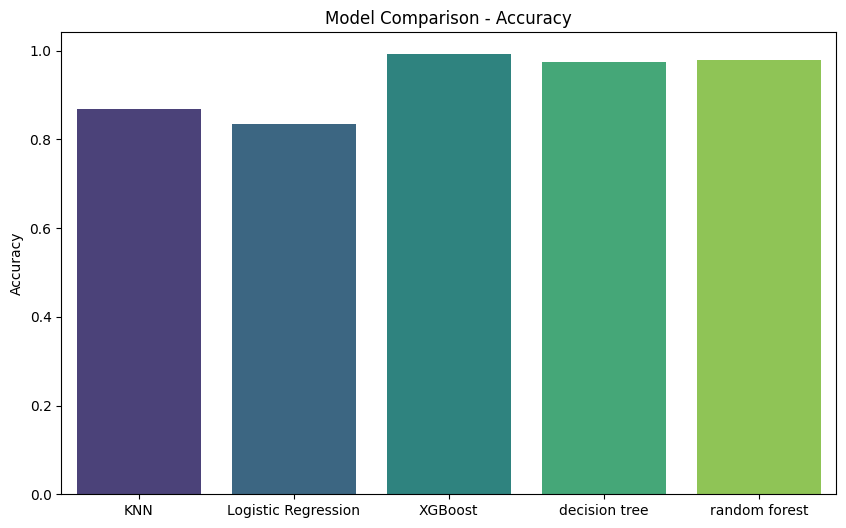

In [31]:
models = [knn, logreg, xgboost , decision_tree , random_forest]
model_names = ['KNN', 'Logistic Regression', 'XGBoost' , 'decision tree', "random forest"]

# Train and evaluate each model
accuracies = []

for current_model in models:
    current_model.fit(x_train_scaled, y_train)

    # Get predictions
    y_pred = current_model.predict(x_test_scaled)

    accuracy = accuracy_score(y_test, y_pred)
    accuracies.append(accuracy)

# Create a bar plot
plt.figure(figsize=(10, 6))
sns.barplot(x=model_names, y=accuracies, palette="viridis")
plt.title('Model Comparison - Accuracy')
plt.ylabel('Accuracy')
plt.show()